In [191]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as smf
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [192]:
estimate = pd.read_csv('E:/Transit-Casa-Alex/MUNI Rail/Output/Modeling/2016/Quarter_Data.csv',thousands = ',')

In [193]:
estimate['FREQ_S'] = 1 / (estimate['HEADWAY_S'] / 60.0)

estimate['NUM_BUS_STOPS'] = estimate['NUM_BUS_STOPS'] - 1

drop = ['Unnamed: 0',
'STOP_LAT_x',
'STOP_LON_x',
'STOP_LAT_y',
'STOP_LON_y',
'geometry',
'index_right',
'ALAND',
'AWATER',
'COUNTYFP',
'NAME',
'TRACTCE',
'Id',
'Id2',
'Geography',
'geometry_e',
'geometry_f',
'STOP_LAT',
'STOP_LON',
'FID_1']

estimate = estimate.drop(drop,axis = 1)


change = ['BART_FROMS','BART_TOS','ON_BUS','OFF_BUS','CALTRAIN_OFF','CALTRAIN_ON','NUM_BUS_STOPS']

for column in change:
    estimate[column] = estimate[column].fillna(0)
    
    
change = ['Average Hourly Price',
'Count_',
'EDHLTH_RAC_SCALED',
'EDHLTH_WAC_SCALED',
'EMP_RAC_SCALED',
'EMP_WAC_SCALED',
'HOUSING16_SCALED',
'LEISER_RAC_SCALED',
'LEISER_WAC_SCALED',
'OTHER_RAC_SCALED',
'OTHER_WAC_SCALED',
'HH_0VEH',
'INC_0_15',
'INC_100P',
'INC_15_50',
'INC_50_100',
'PRICE12HR',
'PRICE1HR',
'PRICE2HR',
'PRICE3HR',
'PRICE4HR',
'PRICEDAY',
'PRICEDAYDISCOUNT',
'RETAIL_RAC_SCALED',
'RETAIL_WAC_SCALED',
'HH_SIZE',
'parking_rate']

changes = ['PARK_HOURLY_AVG_ON',
'TRANSBAY',
'EDHLTH_RAC_DEN',
'EDHLTH_WAC_DEN',
'EMP_RAC_DEN',
'EMP_WAC_DEN',
'HOUSING_16_DEN',
'LEISER_RAC_DEN',
'LEISER_WAC_DEN',
'OTHER_RAC_DEN',
'OTHER_WAC_DEN',
'SHR_HH_0VEH',
'SHR_INCOME_0_15',
'SHR_INCOME_100P',
'SHR_INCOME_15_50',
'SHR_INCOME_50_100',
'PARK_12_HR_OFF_PUB',
'PARK_1_HR_OFF_PUB',
'PARK_2_HR_OFF_PUB',
'PARK_3_HR_OFF_PUB',
'PARK_4_HR_OFF_PUB',
'PARK_DAY_OFF_PUB',
'PARK_DAY_DISCOUNT_OFF_PUB',
'RETAIL_RAC_DEN',
'RETAIL_WAC_DEN',
'AVG_HH_SIZE',
'PARKING_RATE_OFF_RESIDENTIAL']


def rename_column(old_columns,new_columns,df):
    num = len(old_columns)
    count = 0
    while count < num:
        df[new_columns[count]] = df[old_columns[count]]
        df = df.drop(old_columns[count],axis = 1)
        
        count = count + 1
    return df


estimate = rename_column(change,changes,estimate)

estimate['EXCLUDE'] = 0
check = ['EMP_WAC_DEN','LEISER_RAC_DEN','LEISER_WAC_DEN','OTHER_RAC_DEN','OTHER_WAC_DEN','RETAIL_RAC_DEN','RETAIL_WAC_DEN',' Total Boardings ']
count = 0
for column in check:
    while count < len(estimate[column]):
        if np.isnan(estimate[column][count]):
                print('Got One')
                estimate['EXCLUDE'][count] = 1
        count = count + 1
        
data = estimate[estimate['EXCLUDE'] == 0]

data['AVG_RIDE'] = (data[' Total Boardings '] + data[' Total Alightings '])/2
data['LOG_RIDERS'] = np.log(data.AVG_RIDE + 1)
data['AVG_BART'] = (data['BART_FROMS']+data['BART_TOS'])/2
data['CALTRAIN_AVG'] = (data.CALTRAIN_OFF + data.CALTRAIN_ON)/2
data['MUNI_BUS_AVG'] = (data.ON_BUS + data.OFF_BUS)/2


log_change = ['PARK_12_HR_OFF_PUB',   
'PARK_1_HR_OFF_PUB',
'PARK_2_HR_OFF_PUB',
'PARK_3_HR_OFF_PUB',
'PARK_4_HR_OFF_PUB',
'AVG_BART',
'AVG_HH_SIZE',
'BART_FROMS',
'BART_TOS',
'CALTRAIN_AVG',
'CALTRAIN_OFF',
'CALTRAIN_ON',
'PARK_DAY_DISCOUNT_OFF_PUB',
'PARK_DAY_OFF_PUB',
'DWELL_S',
'EDD_EMP',
'EDHLTH_RAC_DEN',
'EDHLTH_WAC_DEN',
'EMP_RAC_DEN',
'EMP_WAC_DEN',
'FREQ_S',
'HEADWAY_S',
'HH_DEN_ACS',
'PARK_HOURLY_AVG_ON',
'HOUSING_16_DEN',
'HU_DEN_ACS',
'LEISER_RAC_DEN',
'LEISER_WAC_DEN',
'NUM_BUS_STOPS',
'OCC_RATE',
'OFF_BUS',
'ON_BUS',
'ONTIME5_BUS',
'OTHER_RAC_DEN',
'OTHER_WAC_DEN',
'PARKING_RATE_OFF_RESIDENTIAL',
'POP_ACS',
'RETAIL_RAC_DEN',
'RETAIL_WAC_DEN',
'RUNSPEED_S',
'RUNTIME_S',
'SHR_HH_0VEH',
'SHR_INCOME_0_15',
'SHR_INCOME_100P',
'SHR_INCOME_15_50',
'SHR_INCOME_50_100',
'TOTSPEED_S',
'TOTTIME_S',
'VAC_RATE']

for column in log_change:
    data[column + '_LOG'] = data[column].apply(lambda value: np.log(value + 1))

def check(value):
    if value == 'N':
        value = ''
    else:
        value = value
    return value


data['DIST_FROM_LAST_STOP'] = data['SERVMILES_S'] / (data['FREQ_S']*24)

data['DIST_FROM_LAST_STOP_LOG'] = data['DIST_FROM_LAST_STOP'].apply(lambda value: np.log(value + 1))

data['SERVMILES_S_LOG'] = data['SERVMILES_S'].apply(lambda x : np.log(x + 1))

data['CAL_STATION'] = np.where(data['CALTRAIN_AVG'] > 0,1,0)

#this should be 0.5 for quarter mile buffers and .2 for tenth
data['CLOSE_STOP'] = np.where(data['DIST_FROM_LAST_STOP'] < 0.5, 1,0)


data['EOL_SOL'] = data['EOL'] + data['SOL']

In [194]:
estimate.columns

Index(['STOP_ID', 'ROUTE_SHORT_NAME', 'DIR', 'STOP NAME_x', 'Stop Latitude',
       ' Total Alightings ', 'Stop Longitude', ' Total Boardings ', 'SEQ',
       'HEADWAY_S', 'EOL', 'SOL', 'DWELL_S', 'RUNTIME_S', 'TOTTIME_S',
       'SERVMILES_S', 'RUNSPEED_S', 'TOTSPEED_S', 'STOP NAME_y', 'POP_ACS',
       'HU_ACS', 'VAC_RATE', 'OCC_RATE', 'POPDEN_ACS', 'HH_DEN_ACS',
       'HU_DEN_ACS', 'BART_TOS', 'BART_FROMS', 'CALTRAIN_OFF', 'CALTRAIN_ON',
       'ON_BUS', 'HEADWAY_S_BUS', 'ONTIME5_BUS', 'OFF_BUS', 'NUM_BUS_STOPS',
       'EDD_EMP', 'geometry_d', 'DIR_e', 'DWELL_S_e', 'EOL_e', 'HEADWAY_S_e',
       'ROUTE_SHOR', 'RUNSPEED_S_e', 'RUNTIME_S_e', 'SEQ_e', 'SERVMILES_',
       'SOL_e', 'STOP_NAME', 'Stop_Latit', 'Stop_Longi', 'Sum_ID',
       'Sum_OBJECT', 'Sum_Value', 'TOTSPEED_S_e', 'TOTTIME_S_e', 'Total_Ali',
       'Total_Boa', 'FREQ_S', 'PARK_HOURLY_AVG_ON', 'TRANSBAY',
       'EDHLTH_RAC_DEN', 'EDHLTH_WAC_DEN', 'EMP_RAC_DEN', 'EMP_WAC_DEN',
       'HOUSING_16_DEN', 'LEISER_RAC_DEN',

In [195]:
data.head()

,STOP_ID,ROUTE_SHORT_NAME,DIR,STOP NAME_x,Stop Latitude,Total Alightings,Stop Longitude,Total Boardings,SEQ,HEADWAY_S,EOL,SOL,DWELL_S,RUNTIME_S,TOTTIME_S,SERVMILES_S,RUNSPEED_S,TOTSPEED_S,STOP NAME_y,POP_ACS,HU_ACS,VAC_RATE,OCC_RATE,POPDEN_ACS,HH_DEN_ACS,HU_DEN_ACS,BART_TOS,BART_FROMS,CALTRAIN_OFF,CALTRAIN_ON,ON_BUS,HEADWAY_S_BUS,ONTIME5_BUS,OFF_BUS,NUM_BUS_STOPS,EDD_EMP,geometry_d,DIR_e,DWELL_S_e,EOL_e,HEADWAY_S_e,ROUTE_SHOR,RUNSPEED_S_e,RUNTIME_S_e,SEQ_e,SERVMILES_,SOL_e,STOP_NAME,Stop_Latit,Stop_Longi,Sum_ID,Sum_OBJECT,Sum_Value,TOTSPEED_S_e,TOTTIME_S_e,Total_Ali,Total_Boa,FREQ_S,PARK_HOURLY_AVG_ON,TRANSBAY,EDHLTH_RAC_DEN,EDHLTH_WAC_DEN,EMP_RAC_DEN,EMP_WAC_DEN,HOUSING_16_DEN,LEISER_RAC_DEN,LEISER_WAC_DEN,OTHER_RAC_DEN,OTHER_WAC_DEN,SHR_HH_0VEH,SHR_INCOME_0_15,SHR_INCOME_100P,SHR_INCOME_15_50,SHR_INCOME_50_100,PARK_12_HR_OFF_PUB,PARK_1_HR_OFF_PUB,PARK_2_HR_OFF_PUB,PARK_3_HR_OFF_PUB,PARK_4_HR_OFF_PUB,PARK_DAY_OFF_PUB,PARK_DAY_DISCOUNT_OFF_PUB,RETAIL_RAC_DEN,RETAIL_WAC_DEN,AVG_HH_SIZE,PARKING_RATE_OFF_RESIDENTIAL,EXCLUDE,AVG_RIDE,LOG_RIDERS,AVG_BART,CALTRAIN_AVG,MUNI_BUS_AVG,PARK_12_HR_OFF_PUB_LOG,PARK_1_HR_OFF_PUB_LOG,PARK_2_HR_OFF_PUB_LOG,PARK_3_HR_OFF_PUB_LOG,PARK_4_HR_OFF_PUB_LOG,AVG_BART_LOG,AVG_HH_SIZE_LOG,BART_FROMS_LOG,BART_TOS_LOG,CALTRAIN_AVG_LOG,CALTRAIN_OFF_LOG,CALTRAIN_ON_LOG,PARK_DAY_DISCOUNT_OFF_PUB_LOG,PARK_DAY_OFF_PUB_LOG,DWELL_S_LOG,EDD_EMP_LOG,EDHLTH_RAC_DEN_LOG,EDHLTH_WAC_DEN_LOG,EMP_RAC_DEN_LOG,EMP_WAC_DEN_LOG,FREQ_S_LOG,HEADWAY_S_LOG,HH_DEN_ACS_LOG,PARK_HOURLY_AVG_ON_LOG,HOUSING_16_DEN_LOG,HU_DEN_ACS_LOG,LEISER_RAC_DEN_LOG,LEISER_WAC_DEN_LOG,NUM_BUS_STOPS_LOG,OCC_RATE_LOG,OFF_BUS_LOG,ON_BUS_LOG,ONTIME5_BUS_LOG,OTHER_RAC_DEN_LOG,OTHER_WAC_DEN_LOG,PARKING_RATE_OFF_RESIDENTIAL_LOG,POP_ACS_LOG,RETAIL_RAC_DEN_LOG,RETAIL_WAC_DEN_LOG,RUNSPEED_S_LOG,RUNTIME_S_LOG,SHR_HH_0VEH_LOG,SHR_INCOME_0_15_LOG,SHR_INCOME_100P_LOG,SHR_INCOME_15_50_LOG,SHR_INCOME_50_100_LOG,TOTSPEED_S_LOG,TOTTIME_S_LOG,VAC_RATE_LOG,DIST_FROM_LAST_STOP,DIST_FROM_LAST_STOP_LOG,SERVMILES_S_LOG,CAL_STATION,CLOSE_STOP,EOL_SOL
0,3212,N,1,9th Ave & Irving St,37.763912,292.4,-122.466240,1046.3,16.0,21.853338,0.0,0.0,0.0,132.00,132.00,16.836,7.65,7.65,9th Ave & Irving St,4467.0,2154.0,0.020891,0.979109,50.827004,23.99690,24.508925,0.0,0.0,0.0,0.0,2986.630246,18.876169,0.586788,2680.466284,10,1857,POLYGON ((-122.4601537301617 37.76401438951365...,1,0.0,0.0,21.853338,N,7.65,132.00,16.0,16.836,0.0,9th Ave & Irving St,37.763912,-122.466240,0,0,0,7.65,132.00,292.4,1046.3,2.745576,200.0,0,760.885760,20558.021890,2876.034865,22804.189271,2644.833441,353.704460,1044.497097,1618.102324,1072.017157,0.223803,0.067330,0.469417,0.132290,0.330963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.342320,129.653128,2.118065,0.802586,0,669.35,6.507800,0.0,0.0,2833.548265,NaN,NaN,NaN,NaN,NaN,0.0,1.137213,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,7.527256,6.635797,9.931055,7.964515,10.034743,1.320575,3.129097,3.218752,5.303305,7.880741,3.239028,5.871285,6.952248,2.397895,0.682647,7.894119,8.002236,0.461712,7.389627,6.978230,0.589222,8.404696,4.972188,4.872546,2.157559,4.890349,0.201963,0.065161,0.384866,0.124242,0.285902,2.157559,4.890349,0.020676,0.255502,0.227535,2.881219,0,1,0.0
1,3266,L,0,15th Ave & Taraval St,37.743122,313.8,-122.471300,119.6,13.0,10.237869,0.0,0.0,0.0,86.19,86.19,13.420,9.34,9.34,15th Ave & Taraval St,5681.0,2402.0,0.104080,0.895920,18.492738,7.00517,7.818968,0.0,0.0,0.0,0.0,1203.674750,25.612057,0.582901,1133.604612,8,1319,POLYGON ((-122.4652114399149 37.74322565099801...,0,0.0,0.0,10.237869,L,9.34,86.19,13.0,13.420,0.0,15th Ave & Taraval St,37.743122,-122.471300,0,0,0,9.34,86.19,313.8,119.6,5.860595,200.0,0,431.765859,292.041899,1972.939397,681.402754,1329.898435,241.825853,41.291253,1165.282502,218.589524,0.090613,0.034851,0.694703,0.134758,0.135688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.065183,129.480078,2.639870,1.655921,0,216.70,5.383118,0.0,0.0,1168.639681,NaN,NaN,NaN,NaN,NaN,0.0,1.291948,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,7.185387,6.070197,5.680316,7.587787,6.525620,1.925794,2.

In [201]:
def set_route_dummy(row,route):
    if row == route:
        value = 1
    else:
        value = 0
    return value

In [203]:
for name in data.ROUTE_SHORT_NAME:
    data[name] = data['ROUTE_SHORT_NAME'].apply(lambda row: set_route_dummy(row,name))

In [196]:
def set_underground(value,stop_list):
    if value in stop_list:
        under = 1
    else:
        under = 0
    return under

In [197]:
stop_list = [6996,6995,5417,5731,6994,5730,6992,7217,6997,5727]

In [198]:
data['UNDERGROUND'] = data.STOP_ID.apply(lambda value: set_underground(value,stop_list))
data = data[data['AVG_RIDE'] > 0]

In [207]:
#Run the 2009 Model
# -- Looks pretty good but he muni bus variable is insignificant


mod = smf.formula.ols(formula="LOG_RIDERS \
                       ~ EDD_EMP_LOG \
                       + FREQ_S_LOG \
                       + HOUSING_16_DEN_LOG \
                       + AVG_BART_LOG \
                       + CLOSE_STOP \
                       + EOL_SOL \
                       + MUNI_BUS_AVG \
                       + J \
                       -1",
             data = data)

res = mod.fit()
print(res.summary())
                    


                            OLS Regression Results                            
Dep. Variable:             LOG_RIDERS   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     3908.
Date:                Wed, 26 Jul 2017   Prob (F-statistic):          3.98e-291
Time:                        15:27:21   Log-Likelihood:                -259.71
No. Observations:                 299   AIC:                             535.4
Df Residuals:                     291   BIC:                             565.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
EDD_EMP_LOG            0.2705      0

In [208]:
bad = []
for num in res.resid:
    if num < -1:
        bad.append(num)
    else:
        bad = bad

In [209]:
print(max(res.resid))
print(min(res.resid))


1.51240480584
-2.16650889673


In [210]:
bad

[-1.076668247096868,
 -1.5916743690644157,
 -1.3044729323262141,
 -1.2505964315689102,
 -1.0995291782684546,
 -1.1224320066700715,
 -1.1534657228703589,
 -1.2870988847593208,
 -1.5435128113028274,
 -1.0488023125443204,
 -1.7089458078885791,
 -1.8153758018907507,
 -1.0176423321813726,
 -1.0062589427101827,
 -2.1665088967284074]

In [211]:
bad_index = []

In [212]:
residual = pd.DataFrame(res.resid)

In [213]:
outliers = residual[residual[0] < -1]

In [214]:
outliers.index

Int64Index([3, 4, 13, 44, 45, 53, 83, 154, 157, 161, 201, 202, 255, 256, 306], dtype='int64')

In [215]:
data['index'] = data.index

In [216]:
bad = pd.DataFrame()
for outlier in outliers:
    bad = data[data['index'] ==  outlier]
    bad = bad.append(bad)

In [217]:
bad

,STOP_ID,ROUTE_SHORT_NAME,DIR,STOP NAME_x,Stop Latitude,Total Alightings,Stop Longitude,Total Boardings,SEQ,HEADWAY_S,EOL,SOL,DWELL_S,RUNTIME_S,TOTTIME_S,SERVMILES_S,RUNSPEED_S,TOTSPEED_S,STOP NAME_y,POP_ACS,HU_ACS,VAC_RATE,OCC_RATE,POPDEN_ACS,HH_DEN_ACS,HU_DEN_ACS,BART_TOS,BART_FROMS,CALTRAIN_OFF,CALTRAIN_ON,ON_BUS,HEADWAY_S_BUS,ONTIME5_BUS,OFF_BUS,NUM_BUS_STOPS,EDD_EMP,geometry_d,DIR_e,DWELL_S_e,EOL_e,HEADWAY_S_e,ROUTE_SHOR,RUNSPEED_S_e,RUNTIME_S_e,SEQ_e,SERVMILES_,SOL_e,STOP_NAME,Stop_Latit,Stop_Longi,Sum_ID,Sum_OBJECT,Sum_Value,TOTSPEED_S_e,TOTTIME_S_e,Total_Ali,Total_Boa,FREQ_S,PARK_HOURLY_AVG_ON,TRANSBAY,EDHLTH_RAC_DEN,EDHLTH_WAC_DEN,EMP_RAC_DEN,EMP_WAC_DEN,HOUSING_16_DEN,LEISER_RAC_DEN,LEISER_WAC_DEN,OTHER_RAC_DEN,OTHER_WAC_DEN,SHR_HH_0VEH,SHR_INCOME_0_15,SHR_INCOME_100P,SHR_INCOME_15_50,SHR_INCOME_50_100,PARK_12_HR_OFF_PUB,PARK_1_HR_OFF_PUB,PARK_2_HR_OFF_PUB,PARK_3_HR_OFF_PUB,PARK_4_HR_OFF_PUB,PARK_DAY_OFF_PUB,PARK_DAY_DISCOUNT_OFF_PUB,RETAIL_RAC_DEN,RETAIL_WAC_DEN,AVG_HH_SIZE,PARKING_RATE_OFF_RESIDENTIAL,EXCLUDE,AVG_RIDE,LOG_RIDERS,AVG_BART,CALTRAIN_AVG,MUNI_BUS_AVG,PARK_12_HR_OFF_PUB_LOG,PARK_1_HR_OFF_PUB_LOG,PARK_2_HR_OFF_PUB_LOG,PARK_3_HR_OFF_PUB_LOG,PARK_4_HR_OFF_PUB_LOG,AVG_BART_LOG,AVG_HH_SIZE_LOG,BART_FROMS_LOG,BART_TOS_LOG,CALTRAIN_AVG_LOG,CALTRAIN_OFF_LOG,CALTRAIN_ON_LOG,PARK_DAY_DISCOUNT_OFF_PUB_LOG,PARK_DAY_OFF_PUB_LOG,DWELL_S_LOG,EDD_EMP_LOG,EDHLTH_RAC_DEN_LOG,EDHLTH_WAC_DEN_LOG,EMP_RAC_DEN_LOG,EMP_WAC_DEN_LOG,FREQ_S_LOG,HEADWAY_S_LOG,HH_DEN_ACS_LOG,PARK_HOURLY_AVG_ON_LOG,HOUSING_16_DEN_LOG,HU_DEN_ACS_LOG,LEISER_RAC_DEN_LOG,LEISER_WAC_DEN_LOG,NUM_BUS_STOPS_LOG,OCC_RATE_LOG,OFF_BUS_LOG,ON_BUS_LOG,ONTIME5_BUS_LOG,OTHER_RAC_DEN_LOG,OTHER_WAC_DEN_LOG,PARKING_RATE_OFF_RESIDENTIAL_LOG,POP_ACS_LOG,RETAIL_RAC_DEN_LOG,RETAIL_WAC_DEN_LOG,RUNSPEED_S_LOG,RUNTIME_S_LOG,SHR_HH_0VEH_LOG,SHR_INCOME_0_15_LOG,SHR_INCOME_100P_LOG,SHR_INCOME_15_50_LOG,SHR_INCOME_50_100_LOG,TOTSPEED_S_LOG,TOTTIME_S_LOG,VAC_RATE_LOG,DIST_FROM_LAST_STOP,DIST_FROM_LAST_STOP_LOG,SERVMILES_S_LOG,CAL_STATION,CLOSE_STOP,EOL_SOL,UNDERGROUND,MUNI_BUS_AVG_LOG,N,L,M,J,KT,index
0,3212,N,1,9th Ave & Irving St,37.763912,292.4,-122.46624,1046.3,16.0,21.853338,0.0,0.0,0.0,132.0,132.0,16.836,7.65,7.65,9th Ave & Irving St,4467.0,2154.0,0.020891,0.979109,50.827004,23.9969,24.508925,0.0,0.0,0.0,0.0,2986.630246,18.876169,0.586788,2680.466284,10,1857,POLYGON ((-122.4601537301617 37.76401438951365...,1,0.0,0.0,21.853338,N,7.65,132.0,16.0,16.836,0.0,9th Ave & Irving St,37.763912,-122.46624,0,0,0,7.65,132.0,292.4,1046.3,2.745576,200.0,0,760.88576,20558.02189,2876.034865,22804.189271,2644.833441,353.70446,1044.497097,1618.102324,1072.017157,0.223803,0.06733,0.469417,0.13229,0.330963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.34232,129.653128,2.118065,0.802586,0,669.35,6.5078,0.0,0.0,2833.548265,NaN,NaN,NaN,NaN,NaN,0.0,1.137213,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,7.527256,6.635797,9.931055,7.964515,10.034743,1.320575,3.129097,3.218752,5.303305,7.880741,3.239028,5.871285,6.952248,2.397895,0.682647,7.894119,8.002236,0.461712,7.389627,6.97823,0.589222,8.404696,4.972188,4.872546,2.157559,4.890349,0.201963,0.065161,0.384866,0.124242,0.285902,2.157559,4.890349,0.020676,0.255502,0.227535,2.881219,0,1,0.0,0,7.949638,1,0,0,0,0,0
0,3212,N,1,9th Ave & Irving St,37.763912,292.4,-122.46624,1046.3,16.0,21.853338,0.0,0.0,0.0,132.0,132.0,16.836,7.65,7.65,9th Ave & Irving St,4467.0,2154.0,0.020891,0.979109,50.827004,23.9969,24.508925,0.0,0.0,0.0,0.0,2986.630246,18.876169,0.586788,2680.466284,10,1857,POLYGON ((-122.4601537301617 37.76401438951365...,1,0.0,0.0,21.853338,N,7.65,132.0,16.0,16.836,0.0,9th Ave & Irving St,37.763912,-122.46624,0,0,0,7.65,132.0,292.4,1046.3,2.745576,200.0,0,760.88576,20558.02189,2876.034865,22804.189271,2644.833441,353.70446,1044.497097,1618.102324,1072.017157,0.223803,0.06733,0.469417,0.13229,0.330963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.34232,129.653128,2.118065,0.802586,0,669.35,6.5078,0.0,0.0,2833.548265,NaN,NaN,NaN,NaN,NaN,0.0,1.137213,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,7.527256

In [218]:
data.to_csv('E:/Transit-Casa-Alex/MUNI Rail/Output/Modeling/2016/Final_Model_Data.csv')

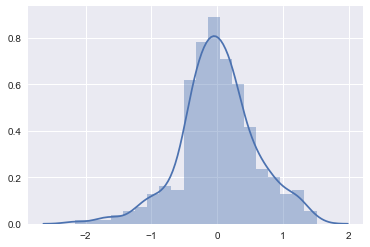

In [219]:
sns.distplot(res.resid)

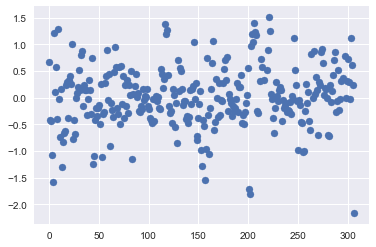

In [220]:
plt.scatter(res.resid.index,res.resid)

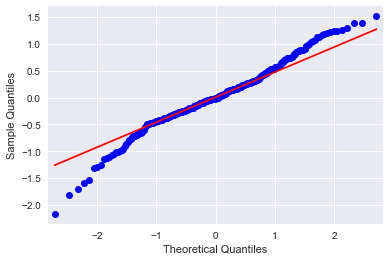

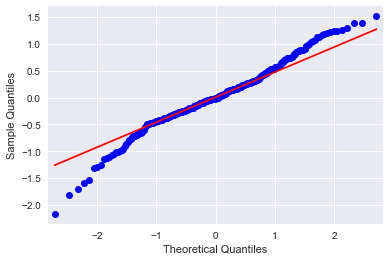

In [221]:
smf.graphics.qqplot(res.resid,line = 'q')

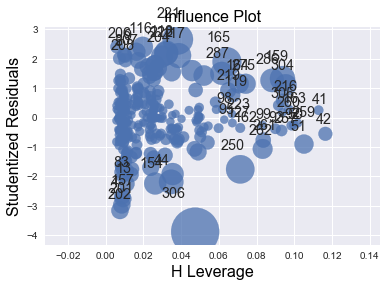

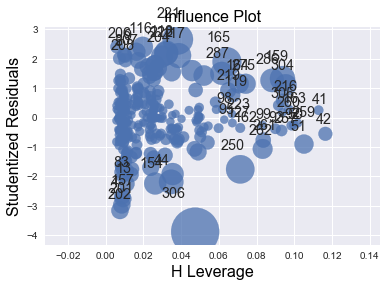

In [222]:
smf.graphics.influence_plot(res)

In [223]:
min(res.resid)

-2.1665088967284074

In [224]:
max(res.resid)

1.512404805839024

In [227]:
dropped = data[['LOG_RIDERS','EDD_EMP_LOG','STOP_ID','AVG_RIDE','FREQ_S_LOG','EOL_SOL','HOUSING_16_DEN_LOG','MUNI_BUS_AVG','AVG_BART_LOG','CLOSE_STOP','J']].dropna()

In [229]:
dropped.to_csv('E:/Transit-Casa-Alex/MUNI Rail/Output/Modeling/2016/Final_Model_Data_Post_Drop.csv')